In [66]:
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle

In [67]:
def extract_frames_from_video(video_path, size = 256):
    """
    Extracts frames from a video.

    :param video_path: Path to the video file.
    :return: List of frames as numpy arrays.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (size, size))
        frames.append(frame / size)
    cap.release()
    return frames

def extract_frames_from_video_min(video_path, start_minute, end_minute, size=256):
    """
    Extracts frames from a specified range of minutes in a video.

    :param video_path: Path to the video file.
    :param start_minute: The starting minute from which to extract frames.
    :param end_minute: The ending minute until which to extract frames.
    :param size: The size to which each frame is resized.
    :return: List of frames as numpy arrays.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Convert times to frame numbers
    start_frame = int(start_minute * 60 * fps)
    end_frame = int(end_minute * 60 * fps)

    frames = []
    current_frame = 0
    while True:
        ret, frame = cap.read()
        if not ret or current_frame > end_frame:
            break

        if current_frame >= start_frame:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.resize(frame, (size, size))
            frames.append(frame / size)

        current_frame += 1

    cap.release()
    return frames

def get_clips(frames_list, sequence_size, stride=3):
    """
    Splits the list of frames into clips of a fixed size with a given stride.

    :param frames_list: List of frames.
    :param sequence_size: The number of frames in each clip.
    :param stride: The step size between the start of each clip.
    :return: List of clips.
    """
    clips = []
    for i in range(0, len(frames_list) - sequence_size + 1, stride):
        clip = np.array(frames_list[i:i + sequence_size])  # Creating a clip
        clip = np.expand_dims(clip, axis=-1)  # Adding the channel dimension
        clips.append(clip)
    return clips

def get_training_set_from_video(video_path, sequence_size=16):
    frames = extract_frames_from_video(video_path)
    return np.array(get_clips(frames, sequence_size))

def visualize_frames(training_data, num_sequences=1, num_frames=10):
    """
    Visualizes frames from the training data.

    :param training_data: The training data containing sequences of frames.
    :param num_sequences: Number of sequences to visualize.
    :param num_frames: Number of frames to visualize per sequence.
    """
    for sequence in range(min(num_sequences, len(training_data))):
        fig, axs = plt.subplots(1, num_frames, figsize=(20, 2))
        for frame in range(num_frames):
            axs[frame].imshow(training_data[sequence][frame, :, :, 0], cmap='gray')
            axs[frame].axis('off')
        plt.show()
        
def visualize_as_video(training_data, sequence_idx=0, delay=30):
    """
    Visualizes a sequence of frames as a video.

    :param training_data: The training data containing sequences of frames.
    :param sequence_idx: Index of the sequence to visualize.
    :param delay: Delay between frames in milliseconds.
    """
    sequence = training_data[sequence_idx]
    for frame in sequence:
        frame_display = frame[:, :, 0] 
        cv2.imshow('Frame', frame_display)
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

In [3]:
model = load_model('256x256_10_8_all.h5')

In [35]:
# with open('full_frames.pickle', 'wb') as f:
#     pickle.dump(frames, f)

In [84]:
with open('full_frames_30.pickle', 'rb') as f:
    frames = pickle.load(f)

print(len(frames))

21579


In [86]:
12*60

720

In [87]:
17-14.3333

2.6667000000000005

In [88]:
2.6666*60*30

4799.879999999999

In [91]:
45*30

1350

In [101]:
test_set = np.array(get_clips(frames[0:60*30], 16))
print(f"test set shape: {test_set.shape}")

test set shape: (595, 16, 256, 256, 1)


In [113]:
60*30

1800

In [106]:
595*3

1785

In [74]:
def plot_images(original, n=4):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(256, 256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def plot_reconstructed_images(original, reconstructed, n=3):
    error = np.mean((original - reconstructed)**2)  # Mean Squared Error
    print(f"MSE: {error}")
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(256, 256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(256, 256))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [102]:
predictions = model.predict(test_set)

In [103]:
with open('predictions_5:00.pickle', 'wb') as f:
    pickle.dump(predictions, f)

MSE: 0.012727667195070163


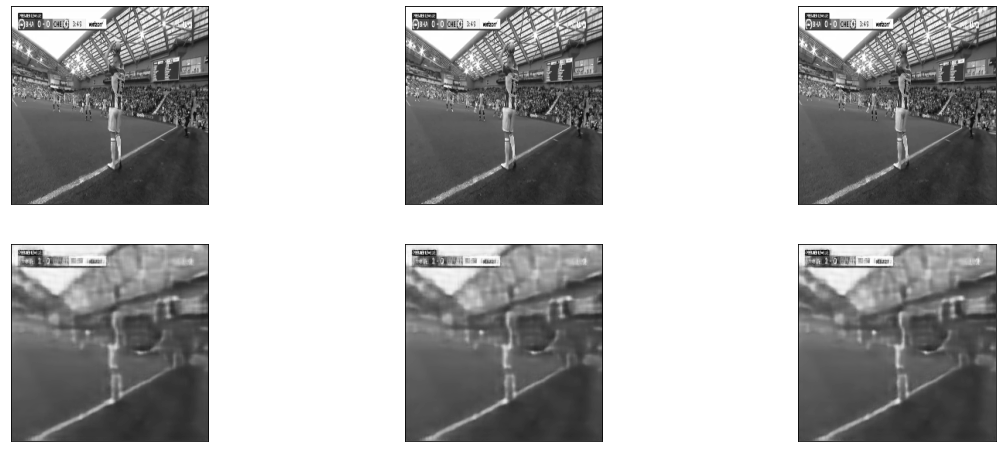

In [110]:
sample = 101
plot_reconstructed_images(test_set[sample], predictions[sample])

In [111]:
video_length

60.0

In [114]:
frame_rate = 30
total_frames = 60*30
video_length = total_frames/30
frame_scores = np.zeros(total_frames)
frame_counts = np.zeros(total_frames)
squared_deviations = np.zeros(total_frames)
stride = 3

clip_length = predictions.shape[1]
num_clips = predictions.shape[0]

for clip_idx in range(num_clips):
    start_frame = clip_idx * stride
    for frame_idx in range(clip_length):
        global_frame_idx = start_frame + frame_idx
        if global_frame_idx < total_frames:
            predicted_frame = predictions[clip_idx, frame_idx]
            original_frame = test_set[clip_idx, frame_idx]
            error = np.mean((original_frame - predicted_frame) ** 2)
            frame_scores[global_frame_idx] += error
            frame_counts[global_frame_idx] += 1

frame_counts[frame_counts == 0] = 1
average_scores = frame_scores / frame_counts

for clip_idx in range(num_clips):
    start_frame = clip_idx * stride
    for frame_idx in range(clip_length):
        global_frame_idx = start_frame + frame_idx
        if global_frame_idx < total_frames:
            error = np.mean((test_set[clip_idx, frame_idx] - predictions[clip_idx, frame_idx]) ** 2)
            squared_deviations[global_frame_idx] += (error - average_scores[global_frame_idx]) ** 2

std_scores = np.sqrt(squared_deviations / frame_counts)

In [116]:
with open('average_scores_5:00.pickle', 'wb') as f:
    pickle.dump(average_scores, f)

In [117]:
with open('std_scores_5:00.pickle', 'wb') as f:
    pickle.dump(std_scores, f)

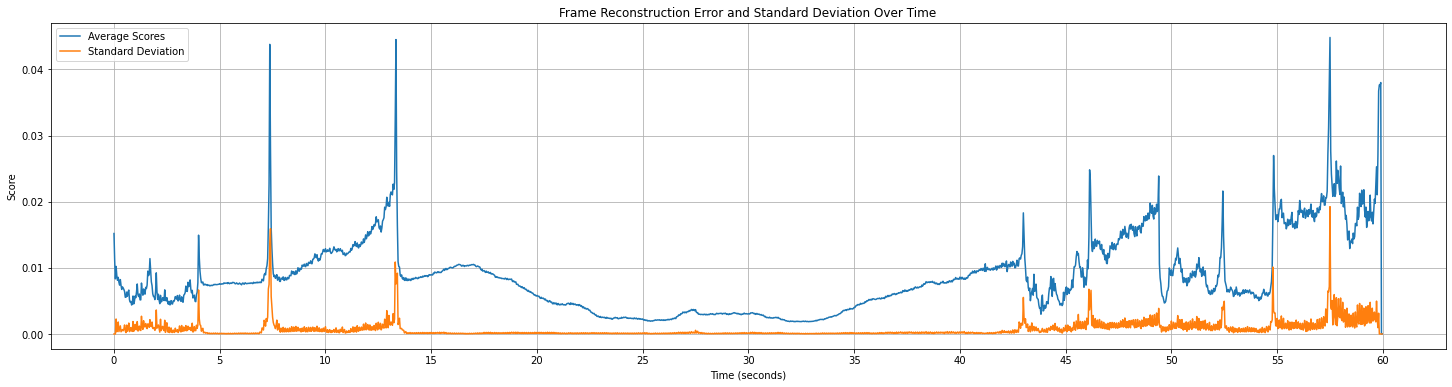

In [115]:
time_axis = np.arange(len(average_scores)) / 30 

plt.figure(figsize=(25, 6))
plt.plot(time_axis, average_scores, label='Average Scores')
plt.plot(time_axis, std_scores, label='Standard Deviation')

plt.title("Frame Reconstruction Error and Standard Deviation Over Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Score")
plt.grid(True)

# Setting ticks at every 5 seconds
plt.xticks(np.arange(0, max(time_axis) + 1, 5))

# Adding a legend
plt.legend()

# Display the plot
plt.show()